# About this Notebook

Bayesian temporal matrix factorization is a type of Bayesian matrix factorization that achieves state-of-the-art results on challenging imputation and prediction problems. In the following, we will discuss:

- What the proposed Bayesian temporal matrix factorization (BTTF for short) is?

- How to implement BTMF mainly using Python `Numpy` with high efficiency?

- How to develop a spatiotemporal prediction model by adapting BTTF?

- How to make predictions with real-world spatiotemporal datasets?


In [1]:
import numpy as np
from numpy import linalg as LA
from numpy.random import multivariate_normal
from scipy.stats import wishart

def Normal_Wishart(mu_0, lamb, W, nu, seed = None):
    """Function drawing a Gaussian-Wishart random variable"""
    Lambda = wishart(df = nu, scale = W, seed = seed).rvs()
    cov = np.linalg.inv(lamb * Lambda)
    mu = multivariate_normal(mu_0, cov)
    return mu, Lambda

# Matrix Computation Concepts

## Kronecker product

- **Definition**:

Given two matrices $A\in\mathbb{R}^{m_1\times n_1}$ and $B\in\mathbb{R}^{m_2\times n_2}$, then, the **Kronecker product** between these two matrices is defined as

$$A\otimes B=\left[ \begin{array}{cccc} a_{11}B & a_{12}B & \cdots & a_{1m_2}B \\ a_{21}B & a_{22}B & \cdots & a_{2m_2}B \\ \vdots & \vdots & \ddots & \vdots \\ a_{m_11}B & a_{m_12}B & \cdots & a_{m_1m_2}B \\ \end{array} \right]$$
where the symbol $\otimes$ denotes Kronecker product, and the size of resulted $A\otimes B$ is $(m_1m_2)\times (n_1n_2)$ (i.e., $m_1\times m_2$ columns and $n_1\times n_2$ rows).

- **Example**:

If $A=\left[ \begin{array}{cc} 1 & 2 \\ 3 & 4 \\ \end{array} \right]$ and $B=\left[ \begin{array}{ccc} 5 & 6 & 7\\ 8 & 9 & 10 \\ \end{array} \right]$, then, we have

$$A\otimes B=\left[ \begin{array}{cc} 1\times \left[ \begin{array}{ccc} 5 & 6 & 7\\ 8 & 9 & 10\\ \end{array} \right] & 2\times \left[ \begin{array}{ccc} 5 & 6 & 7\\ 8 & 9 & 10\\ \end{array} \right] \\ 3\times \left[ \begin{array}{ccc} 5 & 6 & 7\\ 8 & 9 & 10\\ \end{array} \right] & 4\times \left[ \begin{array}{ccc} 5 & 6 & 7\\ 8 & 9 & 10\\ \end{array} \right] \\ \end{array} \right]$$

$$=\left[ \begin{array}{cccccc} 5 & 6 & 7 & 10 & 12 & 14 \\ 8 & 9 & 10 & 16 & 18 & 20 \\ 15 & 18 & 21 & 20 & 24 & 28 \\ 24 & 27 & 30 & 32 & 36 & 40 \\ \end{array} \right]\in\mathbb{R}^{4\times 6}.$$

## Khatri-Rao product (`kr_prod`)

- **Definition**:

Given two matrices $A=\left( \boldsymbol{a}_1,\boldsymbol{a}_2,...,\boldsymbol{a}_r \right)\in\mathbb{R}^{m\times r}$ and $B=\left( \boldsymbol{b}_1,\boldsymbol{b}_2,...,\boldsymbol{b}_r \right)\in\mathbb{R}^{n\times r}$ with same number of columns, then, the **Khatri-Rao product** (or **column-wise Kronecker product**) between $A$ and $B$ is given as follows,

$$A\odot B=\left( \boldsymbol{a}_1\otimes \boldsymbol{b}_1,\boldsymbol{a}_2\otimes \boldsymbol{b}_2,...,\boldsymbol{a}_r\otimes \boldsymbol{b}_r \right)\in\mathbb{R}^{(mn)\times r}$$
where the symbol $\odot$ denotes Khatri-Rao product, and $\otimes$ denotes Kronecker product.

- **Example**:

If $A=\left[ \begin{array}{cc} 1 & 2 \\ 3 & 4 \\ \end{array} \right]=\left( \boldsymbol{a}_1,\boldsymbol{a}_2 \right) $ and $B=\left[ \begin{array}{cc} 5 & 6 \\ 7 & 8 \\ 9 & 10 \\ \end{array} \right]=\left( \boldsymbol{b}_1,\boldsymbol{b}_2 \right) $, then, we have

$$A\odot B=\left( \boldsymbol{a}_1\otimes \boldsymbol{b}_1,\boldsymbol{a}_2\otimes \boldsymbol{b}_2 \right) $$

$$=\left[ \begin{array}{cc} \left[ \begin{array}{c} 1 \\ 3 \\ \end{array} \right]\otimes \left[ \begin{array}{c} 5 \\ 7 \\ 9 \\ \end{array} \right] & \left[ \begin{array}{c} 2 \\ 4 \\ \end{array} \right]\otimes \left[ \begin{array}{c} 6 \\ 8 \\ 10 \\ \end{array} \right] \\ \end{array} \right]$$

$$=\left[ \begin{array}{cc} 5 & 12 \\ 7 & 16 \\ 9 & 20 \\ 15 & 24 \\ 21 & 32 \\ 27 & 40 \\ \end{array} \right]\in\mathbb{R}^{6\times 2}.$$

In [2]:
def kr_prod(a, b):
    return np.einsum('ir, jr -> ijr', a, b).reshape(a.shape[0] * b.shape[0], -1)

In [3]:
A = np.array([[1, 2], [3, 4]])
B = np.array([[5, 6], [7, 8], [9, 10]])
print(kr_prod(A, B))

[[ 5 12]
 [ 7 16]
 [ 9 20]
 [15 24]
 [21 32]
 [27 40]]


## CP decomposition

### CP Combination (`cp_combination`)

- **Definition**:

The CP decomposition factorizes a tensor into a sum of outer products of vectors. For example, for a third-order tensor $\mathcal{Y}\in\mathbb{R}^{m\times n\times f}$, the CP decomposition can be written as

$$\hat{\mathcal{Y}}=\sum_{s=1}^{r}\boldsymbol{u}_{s}\circ\boldsymbol{v}_{s}\circ\boldsymbol{x}_{s},$$
or element-wise,

$$\hat{y}_{ijt}=\sum_{s=1}^{r}u_{is}v_{js}x_{ts},\forall (i,j,t),$$
where vectors $\boldsymbol{u}_{s}\in\mathbb{R}^{m},\boldsymbol{v}_{s}\in\mathbb{R}^{n},\boldsymbol{x}_{s}\in\mathbb{R}^{f}$ are columns of factor matrices $U\in\mathbb{R}^{m\times r},V\in\mathbb{R}^{n\times r},X\in\mathbb{R}^{f\times r}$, respectively. The symbol $\circ$ denotes vector outer product.

- **Example**:

Given matrices $U=\left[ \begin{array}{cc} 1 & 2 \\ 3 & 4 \\ \end{array} \right]\in\mathbb{R}^{2\times 2}$, $V=\left[ \begin{array}{cc} 1 & 2 \\ 3 & 4 \\ 5 & 6 \\ \end{array} \right]\in\mathbb{R}^{3\times 2}$ and $X=\left[ \begin{array}{cc} 1 & 5 \\ 2 & 6 \\ 3 & 7 \\ 4 & 8 \\ \end{array} \right]\in\mathbb{R}^{4\times 2}$, then if $\hat{\mathcal{Y}}=\sum_{s=1}^{r}\boldsymbol{u}_{s}\circ\boldsymbol{v}_{s}\circ\boldsymbol{x}_{s}$, then, we have

$$\hat{Y}_1=\hat{\mathcal{Y}}(:,:,1)=\left[ \begin{array}{ccc} 31 & 42 & 65 \\ 63 & 86 & 135 \\ \end{array} \right],$$
$$\hat{Y}_2=\hat{\mathcal{Y}}(:,:,2)=\left[ \begin{array}{ccc} 38 & 52 & 82 \\ 78 & 108 & 174 \\ \end{array} \right],$$
$$\hat{Y}_3=\hat{\mathcal{Y}}(:,:,3)=\left[ \begin{array}{ccc} 45 & 62 & 99 \\ 93 & 130 & 213 \\ \end{array} \right],$$
$$\hat{Y}_4=\hat{\mathcal{Y}}(:,:,4)=\left[ \begin{array}{ccc} 52 & 72 & 116 \\ 108 & 152 & 252 \\ \end{array} \right].$$

In [4]:
def cp_combination(U, V, X):
    return np.einsum('is, js, ts -> ijt', U, V, X)

In [5]:
U = np.array([[1, 2], [3, 4]])
V = np.array([[1, 3], [2, 4], [5, 6]])
X = np.array([[1, 5], [2, 6], [3, 7], [4, 8]])
print(cp_combination(U, V, X))
print()
print('tensor size:')
print(cp_combination(U, V, X).shape)

[[[ 31  38  45  52]
  [ 42  52  62  72]
  [ 65  82  99 116]]

 [[ 63  78  93 108]
  [ 86 108 130 152]
  [135 174 213 252]]]

tensor size:
(2, 3, 4)


## Tensor Unfolding (`ten2mat`)

Using numpy reshape to perform 3rd rank tensor unfold operation. [[**link**](https://stackoverflow.com/questions/49970141/using-numpy-reshape-to-perform-3rd-rank-tensor-unfold-operation)]

In [6]:
import numpy as np
def ten2mat(tensor, mode):
    return np.reshape(np.moveaxis(tensor, mode, 0), (tensor.shape[mode], -1), order = 'F')

In [7]:
X = np.array([[[1, 2, 3, 4], [3, 4, 5, 6]], [[5, 6, 7, 8], [7, 8, 9, 10]], [[9, 10, 11, 12], [11, 12, 13, 14]]])
print('tensor size:')
print(X.shape)
print('original tensor:')
print(X)
print()
print('(1) mode-1 tensor unfolding:')
print(ten2mat(X, 0))
print()
print('(2) mode-2 tensor unfolding:')
print(ten2mat(X, 1))
print()
print('(3) mode-3 tensor unfolding:')
print(ten2mat(X, 2))

tensor size:
(3, 2, 4)
original tensor:
[[[ 1  2  3  4]
  [ 3  4  5  6]]

 [[ 5  6  7  8]
  [ 7  8  9 10]]

 [[ 9 10 11 12]
  [11 12 13 14]]]

(1) mode-1 tensor unfolding:
[[ 1  3  2  4  3  5  4  6]
 [ 5  7  6  8  7  9  8 10]
 [ 9 11 10 12 11 13 12 14]]

(2) mode-2 tensor unfolding:
[[ 1  5  9  2  6 10  3  7 11  4  8 12]
 [ 3  7 11  4  8 12  5  9 13  6 10 14]]

(3) mode-3 tensor unfolding:
[[ 1  5  9  3  7 11]
 [ 2  6 10  4  8 12]
 [ 3  7 11  5  9 13]
 [ 4  8 12  6 10 14]]


In [8]:
def BTTF(dense_tensor, sparse_tensor, U, V, X, theta, time_lags, maxiter1, maxiter2):
    dim1 = sparse_tensor.shape[0]
    dim2 = sparse_tensor.shape[1]
    dim3 = sparse_tensor.shape[2]
    d = theta.shape[0]
    pos = np.where((dense_tensor > 0) & (sparse_tensor == 0))
    position = np.where(sparse_tensor > 0)
    binary_tensor = np.zeros((dim1, dim2, dim3))
    binary_tensor[position] = 1
    
    tau = 1
    alpha = 1e-6
    beta = 1e-6
    beta0 = 1
    nu0 = rank
    mu0 = np.zeros((rank))
    W0 = np.eye(rank)
    
    for iter in range(maxiter1):
        U_bar = np.mean(U, axis = 0)
        var_mu0 = (dim1 * U_bar + beta0 * mu0)/(dim1 + beta0)
        var_nu = dim1 + nu0
        var_W = np.linalg.inv(np.linalg.inv(W0) 
                              + dim1 * np.cov(U.T) + dim1 * beta0/(dim1 + beta0)
                             * np.outer(U_bar - mu0, U_bar - mu0))
        var_W = (var_W + var_W.T)/2
        var_mu0, var_Lambda0 = Normal_Wishart(var_mu0, dim1 + beta0, var_W, var_nu, seed = None)
        
        var1 = kr_prod(X, V).T
        var2 = kr_prod(var1, var1)
        var3 = tau * np.matmul(var2, ten2mat(binary_tensor, 0).T).reshape([rank, rank, 
                                                                           dim1]) + np.dstack([var_Lambda0] * dim1)
        var4 = tau * np.matmul(var1, ten2mat(sparse_tensor, 0).T) + np.dstack([np.matmul(var_Lambda0, 
                                                                                         var_mu0)] * dim1)[0, :, :]
        for i in range(dim1):
            var_Lambda1 = var3[ :, :, i]
            inv_var_Lambda1 = np.linalg.inv((var_Lambda1 + var_Lambda1.T)/2)
            var_mu = np.matmul(inv_var_Lambda1, var4[:, i])
            U[i, :] = np.random.multivariate_normal(var_mu, inv_var_Lambda1)

        V_bar = np.mean(V, axis = 0)
        var_mu0 = (dim2 * V_bar + beta0 * mu0)/(dim2 + beta0)
        var_nu = dim2 + nu0
        var_W = np.linalg.inv(np.linalg.inv(W0) 
                              + dim2 * np.cov(V.T) + dim2 * beta0/(dim2 + beta0)
                             * np.outer(V_bar - mu0, V_bar - mu0))
        var_W = (var_W + var_W.T)/2
        var_mu0, var_Lambda0 = Normal_Wishart(var_mu0, dim2 + beta0, var_W, var_nu, seed = None)
        
        var1 = kr_prod(X, U).T
        var2 = kr_prod(var1, var1)
        var3 = tau * np.matmul(var2, ten2mat(binary_tensor, 1).T).reshape([rank, rank, 
                                                                           dim2]) + np.dstack([var_Lambda0] * dim2)
        var4 = tau * np.matmul(var1, ten2mat(sparse_tensor, 1).T) + np.dstack([np.matmul(var_Lambda0, 
                                                                                         var_mu0)] * dim2)[0, :, :]
        for j in range(dim2):
            var_Lambda1 = var3[ :, :, j]
            inv_var_Lambda1 = np.linalg.inv((var_Lambda1 + var_Lambda1.T)/2)
            var_mu = np.matmul(inv_var_Lambda1, var4[:, j])
            V[j, :] = np.random.multivariate_normal(var_mu, inv_var_Lambda1)

        var_nu = dim3 + nu0
        mat0 = X[0 : np.max(time_lags), :]
        mat = np.matmul(mat0.T, mat0)
        new_mat = np.zeros((dim3 - np.max(time_lags), rank))
        for t in range(dim3 - np.max(time_lags)):
            new_mat[t, :] = X[t + np.max(time_lags), :] - np.einsum('ij, ij -> j', 
                                                                 theta, X[t + np.max(time_lags)
                                                                          - time_lags, :])
        mat += np.matmul(new_mat.T, new_mat)
        var_W = np.linalg.inv(np.linalg.inv(W0) + mat)
        var_W = (var_W + var_W.T)/2
        Lambda_x = wishart(df = var_nu, scale = var_W, seed = None).rvs()
        
        var1 = kr_prod(V, U).T
        var2 = kr_prod(var1, var1)
        var3 = tau * np.matmul(var2, ten2mat(binary_tensor, 2).T).reshape([rank, rank, 
                                                                           dim3]) + np.dstack([Lambda_x] * dim3)
        var4 = tau * np.matmul(var1, ten2mat(sparse_tensor, 2).T)
        for t in range(dim3):
            Mt = np.zeros((rank, rank))
            Nt = np.zeros(rank)
            if t >= 0 and t <= np.max(time_lags) - 1:
                Qt = np.zeros(rank)
            else:
                Qt = np.matmul(Lambda_x, np.einsum('ij, ij -> j', theta, X[t - time_lags, :]))
            if t >= 0 and t <= dim3 - np.min(time_lags) - 1:
                if t > np.max(time_lags) - 1 and t <= dim3 - np.max(time_lags) - 1:
                    index = list(range(0, d))
                else:
                    index = list(np.where((t + time_lags > np.max(time_lags) - 1) 
                                          & (t + time_lags <= dim3 - 1)))[0]
                for k in index:
                    Ak = theta[k, :]
                    Mt += np.multiply(np.outer(Ak, Ak), Lambda_x)
                    theta0 = theta.copy()
                    theta0[k, :] = 0
                    var5 = X[t + time_lags[k], :] - np.einsum('ij, ij -> j', 
                                                              theta0, X[t + time_lags[k] 
                                                                        - time_lags, :])
                    Nt += np.matmul(np.matmul(np.diag(Ak), Lambda_x), var5)
            var_mu = var4[:, t] + Nt + Qt
            var_Lambda = var3[:, :, t] + Mt
            inv_var_Lambda = np.linalg.inv((var_Lambda + var_Lambda.T)/2)
            var_mu = np.matmul(inv_var_Lambda, var_mu)
            X[t, :] = np.random.multivariate_normal(var_mu, inv_var_Lambda)
            
        tensor_hat = cp_combination(U, V, X)
        rmse = np.sqrt(np.sum((dense_tensor[pos] - tensor_hat[pos]) ** 2)/dense_tensor[pos].shape[0])
        
        var_alpha = alpha + 0.5 * sparse_tensor[position].shape[0]
        error = sparse_tensor - tensor_hat
        var_beta = beta + 0.5 * np.sum(error[position] ** 2)
        tau = np.random.gamma(var_alpha, 1/var_beta)
        
        theta_bar = np.mean(theta, axis = 0)
        var_mu0 = (d * theta_bar + beta0 * mu0)/(d + beta0)
        var_nu = d + nu0
        var_W = np.linalg.inv(np.linalg.inv(W0) 
                              + d * np.cov(theta.T) + d * beta0/(d + beta0)
                             * np.outer(theta_bar - mu0, theta_bar - mu0))
        var_W = (var_W + var_W.T)/2
        mu_theta, Lambda_theta = Normal_Wishart(var_mu0, d + beta0, var_W, var_nu, seed = None)
        
        for k in range(d):
            theta0 = theta.copy()
            theta0[k, :] = 0
            mat0 = np.zeros((dim3 - np.max(time_lags), rank))
            for L in range(d):
                mat0 += np.matmul(X[np.max(time_lags) - time_lags[L] : dim3 - time_lags[L] , :], 
                                  np.diag(theta0[L, :]))
            VarPi = X[np.max(time_lags) : dim3, :] - mat0
            mat1 = np.zeros((rank, rank))
            mat2 = np.zeros(rank)
            for t in range(np.max(time_lags), dim3):
                B = X[t - time_lags[k], :]
                mat1 += np.multiply(np.outer(B, B), Lambda_x)
                mat2 += np.matmul(np.matmul(np.diag(B), Lambda_x), VarPi[t - np.max(time_lags), :])
            var_Lambda = mat1 + Lambda_theta
            inv_var_Lambda = np.linalg.inv((var_Lambda + var_Lambda.T)/2)
            var_mu = np.matmul(inv_var_Lambda, mat2 + np.matmul(Lambda_theta, mu_theta))
            theta[k, :] = np.random.multivariate_normal(var_mu, inv_var_Lambda)
        
        if (iter + 1) % 100 == 0:
            print('Iter: {}'.format(iter + 1))
            print('RMSE: {:.6}'.format(rmse))
            print()

    U_plus = np.zeros((dim1, rank))
    V_plus = np.zeros((dim2, rank))
    X_plus = np.zeros((dim3, rank))
    theta_plus = np.zeros((d, rank))
    tensor_hat_plus = np.zeros((dim1, dim2, dim3))
    for iters in range(maxiter2):
        U_bar = np.mean(U, axis = 0)
        var_mu0 = (dim1 * U_bar + beta0 * mu0)/(dim1 + beta0)
        var_nu = dim1 + nu0
        var_W = np.linalg.inv(np.linalg.inv(W0) 
                              + dim1 * np.cov(U.T) + dim1 * beta0/(dim1 + beta0)
                             * np.outer(U_bar - mu0, U_bar - mu0))
        var_W = (var_W + var_W.T)/2
        var_mu0, var_Lambda0 = Normal_Wishart(var_mu0, dim1 + beta0, var_W, var_nu, seed = None)
        
        var1 = kr_prod(X, V).T
        var2 = kr_prod(var1, var1)
        var3 = tau * np.matmul(var2, ten2mat(binary_tensor, 0).T).reshape([rank, rank, 
                                                                           dim1]) + np.dstack([var_Lambda0] * dim1)
        var4 = tau * np.matmul(var1, ten2mat(sparse_tensor, 0).T) + np.dstack([np.matmul(var_Lambda0, 
                                                                                         var_mu0)] * dim1)[0, :, :]
        for i in range(dim1):
            var_Lambda1 = var3[ :, :, i]
            inv_var_Lambda1 = np.linalg.inv((var_Lambda1 + var_Lambda1.T)/2)
            var_mu = np.matmul(inv_var_Lambda1, var4[:, i])
            U[i, :] = np.random.multivariate_normal(var_mu, inv_var_Lambda1)
        U_plus += U

        V_bar = np.mean(V, axis = 0)
        var_mu0 = (dim2 * V_bar + beta0 * mu0)/(dim2 + beta0)
        var_nu = dim2 + nu0
        var_W = np.linalg.inv(np.linalg.inv(W0) 
                              + dim2 * np.cov(V.T) + dim2 * beta0/(dim2 + beta0)
                             * np.outer(V_bar - mu0, V_bar - mu0))
        var_W = (var_W + var_W.T)/2
        var_mu0, var_Lambda0 = Normal_Wishart(var_mu0, dim2 + beta0, var_W, var_nu, seed = None)
        
        var1 = kr_prod(X, U).T
        var2 = kr_prod(var1, var1)
        var3 = tau * np.matmul(var2, ten2mat(binary_tensor, 1).T).reshape([rank, rank, 
                                                                           dim2]) + np.dstack([var_Lambda0] * dim2)
        var4 = tau * np.matmul(var1, ten2mat(sparse_tensor, 1).T) + np.dstack([np.matmul(var_Lambda0, 
                                                                                         var_mu0)] * dim2)[0, :, :]
        for j in range(dim2):
            var_Lambda1 = var3[ :, :, j]
            inv_var_Lambda1 = np.linalg.inv((var_Lambda1 + var_Lambda1.T)/2)
            var_mu = np.matmul(inv_var_Lambda1, var4[:, j])
            V[j, :] = np.random.multivariate_normal(var_mu, inv_var_Lambda1)
        V_plus += V

        var_nu = dim3 + nu0
        mat0 = X[0 : np.max(time_lags), :]
        mat = np.matmul(mat0.T, mat0)
        new_mat = np.zeros((dim3 - np.max(time_lags), rank))
        for t in range(dim3 - np.max(time_lags)):
            new_mat[t, :] = X[t + np.max(time_lags), :] - np.einsum('ij, ij -> j', 
                                                                 theta, X[t + np.max(time_lags)
                                                                          - time_lags, :])
        mat += np.matmul(new_mat.T, new_mat)
        var_W = np.linalg.inv(np.linalg.inv(W0) + mat)
        var_W = (var_W + var_W.T)/2
        Lambda_x = wishart(df = var_nu, scale = var_W, seed = None).rvs()
        
        var1 = kr_prod(V, U).T
        var2 = kr_prod(var1, var1)
        var3 = tau * np.matmul(var2, ten2mat(binary_tensor, 2).T).reshape([rank, rank, 
                                                                           dim3]) + np.dstack([Lambda_x] * dim3)
        var4 = tau * np.matmul(var1, ten2mat(sparse_tensor, 2).T)
        for t in range(dim3):
            Mt = np.zeros((rank, rank))
            Nt = np.zeros(rank)
            if t >= 0 and t <= np.max(time_lags) - 1:
                Qt = np.zeros(rank)
            else:
                Qt = np.matmul(Lambda_x, np.einsum('ij, ij -> j', theta, X[t - time_lags, :]))
            if t >= 0 and t <= dim3 - np.min(time_lags) - 1:
                if t > np.max(time_lags) - 1 and t <= dim3 - np.max(time_lags) - 1:
                    index = list(range(0, d))
                else:
                    index = list(np.where((t + time_lags > np.max(time_lags) - 1) 
                                          & (t + time_lags <= dim3 - 1)))[0]
                for k in index:
                    Ak = theta[k, :]
                    Mt += np.multiply(np.outer(Ak, Ak), Lambda_x)
                    theta0 = theta.copy()
                    theta0[k, :] = 0
                    var5 = X[t + time_lags[k], :] - np.einsum('ij, ij -> j', 
                                                              theta0, X[t + time_lags[k] 
                                                                        - time_lags, :])
                    Nt += np.matmul(np.matmul(np.diag(Ak), Lambda_x), var5)
            var_mu = var4[:, t] + Nt + Qt
            var_Lambda = var3[:, :, t] + Mt
            inv_var_Lambda = np.linalg.inv((var_Lambda + var_Lambda.T)/2)
            var_mu = np.matmul(inv_var_Lambda, var_mu)
            X[t, :] = np.random.multivariate_normal(var_mu, inv_var_Lambda)
        X_plus += X
            
        tensor_hat = cp_combination(U, V, X)
        tensor_hat_plus += tensor_hat
        
        var_alpha = alpha + 0.5 * sparse_tensor[position].shape[0]
        error = sparse_tensor - tensor_hat
        var_beta = beta + 0.5 * np.sum(error[position]**2)
        tau = np.random.gamma(var_alpha, 1/var_beta)
        
        theta_bar = np.mean(theta, axis = 0)
        var_mu0 = (d * theta_bar + beta0 * mu0)/(d + beta0)
        var_nu = d + nu0
        var_W = np.linalg.inv(np.linalg.inv(W0) 
                              + d * np.cov(theta.T) + d * beta0/(d + beta0)
                             * np.outer(theta_bar - mu0, theta_bar - mu0))
        var_W = (var_W + var_W.T)/2
        mu_theta, Lambda_theta = Normal_Wishart(var_mu0, d + beta0, var_W, var_nu, seed = None)
        
        for k in range(d):
            theta0 = theta.copy()
            theta0[k, :] = 0
            mat0 = np.zeros((dim3 - np.max(time_lags), rank))
            for L in range(d):
                mat0 += np.matmul(X[np.max(time_lags) - time_lags[L] : dim3 - time_lags[L] , :], 
                                  np.diag(theta0[L, :]))
            VarPi = X[np.max(time_lags) : dim3, :] - mat0
            mat1 = np.zeros((rank, rank))
            mat2 = np.zeros(rank)
            for t in range(np.max(time_lags), dim3):
                B = X[t - time_lags[k], :]
                mat1 += np.multiply(np.outer(B, B), Lambda_x)
                mat2 += np.matmul(np.matmul(np.diag(B), Lambda_x), VarPi[t - np.max(time_lags), :])
            var_Lambda = mat1 + Lambda_theta
            inv_var_Lambda = np.linalg.inv((var_Lambda + var_Lambda.T)/2)
            var_mu = np.matmul(inv_var_Lambda, mat2 + np.matmul(Lambda_theta, mu_theta))
            theta[k, :] = np.random.multivariate_normal(var_mu, inv_var_Lambda)
        theta_plus += theta
            
    U = U_plus/maxiter2
    V = V_plus/maxiter2
    X = X_plus/maxiter2
    theta = theta_plus/maxiter2
    tensor_hat = tensor_hat_plus/maxiter2
    final_mape = np.sum(np.abs(dense_tensor[pos] - 
                               tensor_hat[pos])/dense_tensor[pos])/dense_tensor[pos].shape[0]
    final_rmse = np.sqrt(np.sum((dense_tensor[pos] - 
                                 tensor_hat[pos])**2)/dense_tensor[pos].shape[0])
    print('Final MAPE: {:.6}'.format(final_mape))
    print('Final RMSE: {:.6}'.format(final_rmse))
    print()
    
    return U, V, X, theta

# Online Prediction Problem

**Question**: How to update $\boldsymbol{x}_{t}\in\mathbb{R}^{r}$?

Fixing spatial factor matrix $W\in\mathbb{R}^{m\times r}$.

Bayesian model:

$$y_{it}\sim\mathcal{N}\left(\boldsymbol{w}_{i}^{T}\boldsymbol{x}_{t},\tau^{-1}\right),$$

$$\boldsymbol{x}_{t}\sim\mathcal{N}\left(\sum_{k=1}^{d}\boldsymbol{\theta}_{k}\circledast\boldsymbol{x}_{t-h_k},\Lambda_{x}^{-1}\right),$$

$$\tau\sim\text{Gamma}\left(\alpha,\beta\right),$$

$$\Lambda_{x}\sim\mathcal{W}\left(W_0,\nu_0\right).$$

The posterior distribution of $\Lambda_{x}$ is $\mathcal{W}\left(W_{x}^{*},\nu_{x}^{*}\right)$ in which

$$\left(W_{x}^{*}\right)^{-1}=W_0^{-1}+\left(\boldsymbol{x}_{t}-\tilde{\boldsymbol{x}}_{t}\right)\left(\boldsymbol{x}_{t}-\tilde{\boldsymbol{x}}_{t}\right)^{T},\nu_{x}^{*}=\nu_{0}+1,$$
where $\tilde{\boldsymbol{x}}_{t}=\sum_{k=1}^{d}\boldsymbol{\theta}_{k}\circledast\boldsymbol{x}_{t-h_{k}}$.

The posterior distribution of $\boldsymbol{x}_{t}$ is $\mathcal{N}\left(\boldsymbol{\mu}_{x}^{*},\left(\Lambda_{x}^{*}\right)^{-1}\right)$ in which

$$\Lambda_{x}^{*}=\tau \sum_{i\in \Omega_{t}} \boldsymbol{w}_{i} \boldsymbol{w}_{i}^{T}+\Lambda_{x},~\boldsymbol{\mu}_{x}^{*}=\left(\Lambda_{x}^{*}\right)^{-1}\left(\tau \sum_{i\in \Omega_{t}} \boldsymbol{w}_{i} y_{it}+\Lambda_{x} \tilde{\boldsymbol{x}}_{t}\right).$$

The posterior distribution of $\tau$ is $\text{Gamma}\left(\alpha^{*},\beta^{*}\right)$ in which

$$\alpha^{*}=\frac{1}{2}|\Omega|+\alpha,~\beta^{*}=\frac{1}{2} \sum_{i \in \Omega_{t}}\left(y_{i t}-\boldsymbol{w}_{i}^{T} \boldsymbol{x}_{t}\right)^{2}+\beta.$$

In [9]:
def OnlineBTTF(sparse_mat, U, V, X, theta, time_lags, maxiter1, maxiter2):
    """Online Bayesain Temporal Tensor Factorization"""
    d = theta.shape[0]
    dim1 = sparse_mat.shape[0]
    dim2 = sparse_mat.shape[1]
    dim3 = 1
    sparse_tensor = sparse_mat.reshape([dim1, dim2, dim3])
    t = X.shape[0]
    rank = X.shape[1]
    position = np.where(sparse_tensor > 0)
    binary_tensor = np.zeros((dim1, dim2, dim3))
    binary_tensor[position] = 1

    tau = 1
    alpha = 1e-6
    beta = 1e-6
    beta0 = 1
    nu0 = rank
    mu0 = np.zeros((rank))
    W0 = np.eye(rank)
    X[t - 1, :] = X[t - 2, :].copy()
    xt_tilde = np.einsum('ij, ij -> j', theta, X[t - 1 - time_lags, :])

    for iter in range(maxiter1):
        var_nu = 1 + nu0
        vec0 = X[t - 1, :] - xt_tilde
        mat = np.outer(vec0, vec0)
        var_W = np.linalg.inv(np.linalg.inv(W0) + mat)
        var_W = (var_W + var_W.T)/2
        Lambda_x = wishart(df = var_nu, scale = var_W, seed = None).rvs()
        
        var1 = kr_prod(V, U).T
        var2 = kr_prod(var1, var1)
        var3 = tau * np.matmul(var2, ten2mat(binary_tensor, 2).reshape([dim1 * dim2])).reshape([rank, rank]) + Lambda_x
        var4 = tau * np.matmul(var1, ten2mat(sparse_tensor, 2).reshape([dim1 * dim2]))
        var_mu = var4 + np.matmul(Lambda_x, xt_tilde)
        var_Lambda = (var3 + var3.T)/2
        inv_var_Lambda = np.linalg.inv(var_Lambda)
        var_mu = np.matmul(inv_var_Lambda, var_mu)
        X[t - 1, :] = np.random.multivariate_normal(var_mu, inv_var_Lambda)
        
        tensor_hat = cp_combination(U, V, X)
        
        var_alpha = alpha + 0.5 * sparse_tensor[position].shape[0]
        error = sparse_tensor - tensor_hat
        var_beta = beta + 0.5 * np.sum(error[position] ** 2)
        tau = np.random.gamma(var_alpha, 1/var_beta)

    xt_plus = np.zeros(rank)
    for iter in range(maxiter2):
        var_nu = 1 + nu0
        vec0 = X[t - 1, :] - xt_tilde
        mat = np.outer(vec0, vec0)
        var_W = np.linalg.inv(np.linalg.inv(W0) + mat)
        var_W = (var_W + var_W.T)/2
        Lambda_x = wishart(df = var_nu, scale = var_W, seed = None).rvs()
        
        var1 = kr_prod(V, U).T
        var2 = kr_prod(var1, var1)
        var3 = tau * np.matmul(var2, ten2mat(binary_tensor, 2).reshape([dim1 * dim2])).reshape([rank, rank]) + Lambda_x
        var4 = tau * np.matmul(var1, ten2mat(sparse_tensor, 2).reshape([dim1 * dim2]))
        var_mu = var4 + np.matmul(Lambda_x, xt_tilde)
        var_Lambda = (var3 + var3.T)/2
        inv_var_Lambda = np.linalg.inv(var_Lambda)
        var_mu = np.matmul(inv_var_Lambda, var_mu)
        X[t - 1, :] = np.random.multivariate_normal(var_mu, inv_var_Lambda)
        xt_plus += X[t - 1, :]
        
        tensor_hat = cp_combination(U, V, X)
        
        var_alpha = alpha + 0.5 * sparse_tensor[position].shape[0]
        error = sparse_tensor - tensor_hat
        var_beta = beta + 0.5 * np.sum(error[position] ** 2)
        tau = np.random.gamma(var_alpha, 1/var_beta)

    xt = xt_plus/maxiter2
    X[t - 1, :] = xt
    return X

In [10]:
def st_prediction(dense_tensor, sparse_tensor, pred_time_steps, rank, time_lags, maxiter):
    start_time = dense_tensor.shape[2] - pred_time_steps
    dense_tensor0 = dense_tensor[:, :, 0 : start_time]
    sparse_tensor0 = sparse_tensor[:, :, 0 : start_time]
    dim1 = sparse_tensor0.shape[0]
    dim2 = sparse_tensor0.shape[1]
    dim3 = sparse_tensor0.shape[2]
    tensor_hat = np.zeros((dim1, dim2, pred_time_steps))
    
    U0 = 0.1 * np.random.rand(dim1, rank)
    V0 = 0.1 * np.random.rand(dim2, rank)
    X0 = 0.1 * np.random.rand(dim3, rank)
    theta0 = 0.1 * np.random.rand(time_lags.shape[0], rank)
    U, V, X, theta = BTTF(dense_tensor0, sparse_tensor0, U0, V0, X0, theta0, time_lags, maxiter[0], maxiter[1])
    X0 = np.zeros((dim3 + 1, rank))
    X0[0 : dim3, :] = X
    X0[dim3, :] = np.einsum('ij, ij -> j', theta, X0[dim3 - time_lags, :])
    tensor_hat[:, :, 0] = np.einsum('is, js, s -> ij', U, V, X0[dim3, :])
    
    for t in range(1, pred_time_steps):
        sparse_tensor1 = sparse_tensor[:, :, 0 : start_time + t]
        X = OnlineBTTF(sparse_tensor1[:, :, - 1], U, V, X0, theta, time_lags, maxiter[2], maxiter[3])
        X0 = np.zeros((dim3 + t + 1, rank))
        X0[0 : dim3 + t, :] = X
        X0[dim3 + t, :] = np.einsum('ij, ij -> j', theta, X0[dim3 + t - time_lags, :])
        tensor_hat[:, :, t] = np.einsum('is, js, s -> ij', U, V, X0[dim3 + t, :])
        if (t + 1) % 40 == 0:
            print('Time step: {}'.format(t + 1))

    small_dense_tensor = dense_tensor[:, :, start_time : dense_tensor.shape[2]]
    pos = np.where(small_dense_tensor > 0)
    final_mape = np.sum(np.abs(small_dense_tensor[pos] - 
                               tensor_hat[pos])/small_dense_tensor[pos])/small_dense_tensor[pos].shape[0]
    final_rmse = np.sqrt(np.sum((small_dense_tensor[pos] - 
                                 tensor_hat[pos]) ** 2)/small_dense_tensor[pos].shape[0])
    print('Final MAPE: {:.6}'.format(final_mape))
    print('Final RMSE: {:.6}'.format(final_rmse))
    print()
    return tensor_hat

In [28]:
import scipy.io

tensor = scipy.io.loadmat('NYC-data-set/tensor.mat')
dense_tensor = tensor['tensor']
rm_tensor = scipy.io.loadmat('NYC-data-set/rm_tensor.mat')
rm_tensor = rm_tensor['rm_tensor']
nm_tensor = scipy.io.loadmat('NYC-data-set/nm_tensor.mat')
nm_tensor = nm_tensor['nm_tensor']

missing_rate = 0.3

# =============================================================================
### Random missing (RM) scenario
### Set the RM scenario by:
# binary_tensor = np.round(rm_tensor + 0.5 - missing_rate)
# =============================================================================

# =============================================================================
### Non-random missing (NM) scenario
### Set the NM scenario by:
binary_tensor = np.zeros(dense_tensor.shape)
for i1 in range(dense_tensor.shape[0]):
    for i2 in range(dense_tensor.shape[1]):
        for i3 in range(61):
            binary_tensor[i1, i2, i3 * 24 : (i3 + 1) * 24] = np.round(nm_tensor[i1, i2, i3] 
                                                                      + 0.5 - missing_rate)
# =============================================================================

sparse_tensor = np.multiply(dense_tensor, binary_tensor)

In [29]:
import time
start = time.time()
pred_time_steps = 24 * 7
rank = 30
time_lags = np.array([1, 2, 24])
maxiter = np.array([1000, 500, 100, 100])
small_sparse_tensor = sparse_tensor[:, :, dense_tensor.shape[2] - pred_time_steps : dense_tensor.shape[2]]
small_dense_tensor = dense_tensor[:, :, dense_tensor.shape[2] - pred_time_steps : dense_tensor.shape[2]]
tensor_hat = st_prediction(dense_tensor, sparse_tensor, pred_time_steps, rank, time_lags, maxiter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 100
RMSE: 5.45884

Iter: 200
RMSE: 5.41113

Iter: 300
RMSE: 5.38486

Iter: 400
RMSE: 5.32209

Iter: 500
RMSE: 5.31405

Iter: 600
RMSE: 5.29834

Iter: 700
RMSE: 5.17837

Iter: 800
RMSE: 5.23756

Iter: 900
RMSE: 5.22231

Iter: 1000
RMSE: 5.18652

Final MAPE: 0.518779
Final RMSE: 4.88972

Time step: 40
Time step: 80
Time step: 120
Time step: 160
Final MAPE: 0.565124
Final RMSE: 6.50904

Running time: 4002 seconds


**Experiment results** of short-term traffic prediction with missing values using Bayesian temporal matrix factorization (BTMF):

|  scenario |`back_steps`|`rank`|`time_lags`| `maxiter` |       mape |      rmse |
|:----------|-----:|-----:|---------:|---------:|-----------:|----------:|
|**Original data**| - | 30 | (1,2,24) | (1000,500,500,500) | 0.5883 | **6.5227**|
|**10%, RM**| - | 30 | (1,2,24) | (1000,500,500,500) | 0.5639 | **6.4639**|
|**30%, RM**| - | 30 | (1,2,24) | (1000,500,500,500) | 0.5812 | **6.7355**|
|**10%, NM**| - | 30 | (1,2,24) | (1000,500,100,100) | 0.5598 | **6.3063**|
|**30%, NM**| - | 30 | (1,2,24) | (1000,500,100,100) | 0.5651 | **6.5090**|


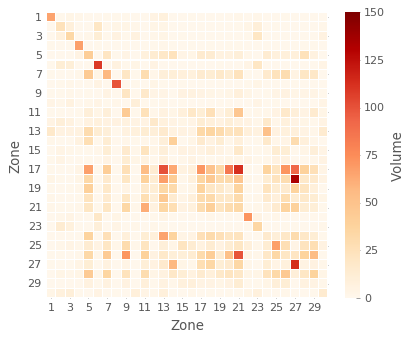

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('bmh')
fig = plt.figure(figsize = (5, 4.2))
ax = fig.add_axes([0.10, 0.10, 0.88, 0.85])
ax = sns.heatmap(small_dense_tensor[:, :, 33 + 48], cmap = 'OrRd', vmin = 0, vmax = 150, linewidth = 0.01,
                cbar_kws={'label': 'Volume'})
plt.xticks(np.arange(0.5, 30, 2), ["1", "3", "5", "7", "9", 
                                "11", "13", "15", "17", "19", 
                                "21", "23", "25", "27", "29"], rotation = 0)
plt.yticks(np.arange(0.5, 30, 2), ["1", "3", "5", "7", "9", 
                                "11", "13", "15", "17", "19", 
                                "21", "23", "25", "27", "29"], rotation = 0)
ax.set_xlabel("Zone")
ax.set_ylabel("Zone")
plt.show()
fig.savefig("images/Ndata_heatmap_actual_values_33.pdf")

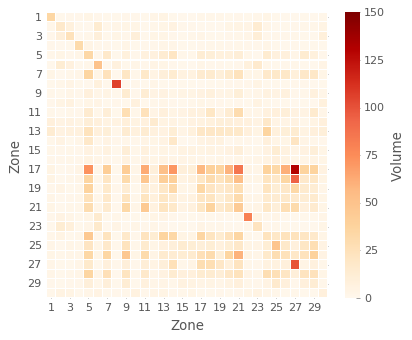

In [31]:
fig = plt.figure(figsize = (5, 4.2))
ax = fig.add_axes([0.10, 0.10, 0.88, 0.85])
ax = sns.heatmap(tensor_hat[:, :, 33 + 48], cmap = 'OrRd', vmin = 0, vmax = 150, linewidth = 0.01,
                cbar_kws={'label': 'Volume'})
plt.xticks(np.arange(0.5, 30, 2), ["1", "3", "5", "7", "9", 
                                "11", "13", "15", "17", "19", 
                                "21", "23", "25", "27", "29"], rotation = 0)
plt.yticks(np.arange(0.5, 30, 2), ["1", "3", "5", "7", "9", 
                                "11", "13", "15", "17", "19", 
                                "21", "23", "25", "27", "29"], rotation = 0)
ax.set_xlabel("Zone")
ax.set_ylabel("Zone")
plt.show()
fig.savefig("images/Ndata_heatmap_predicted_values_33.pdf")

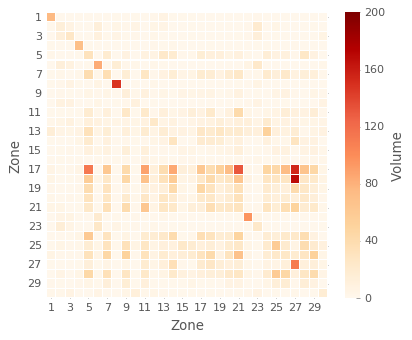

In [32]:
fig = plt.figure(figsize = (5, 4.2))
cmap = sns.cubehelix_palette(light = 1, as_cmap = True)
ax = fig.add_axes([0.10, 0.10, 0.88, 0.85])
ax = sns.heatmap(small_dense_tensor[:, :, 32 + 48], cmap = 'OrRd', vmin = 0, vmax = 200, linewidth = 0.01,
                cbar_kws={'label': 'Volume'})
plt.xticks(np.arange(0.5, 30, 2), ["1", "3", "5", "7", "9", 
                                "11", "13", "15", "17", "19", 
                                "21", "23", "25", "27", "29"], rotation = 0)
plt.yticks(np.arange(0.5, 30, 2), ["1", "3", "5", "7", "9", 
                                "11", "13", "15", "17", "19", 
                                "21", "23", "25", "27", "29"], rotation = 0)
ax.set_xlabel("Zone")
ax.set_ylabel("Zone")
plt.show()
fig.savefig("images/Ndata_heatmap_actual_values_32.pdf")

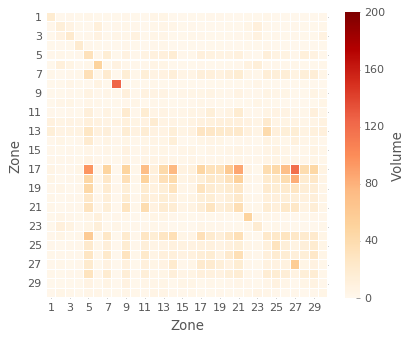

In [33]:
fig = plt.figure(figsize = (5, 4.2))
cmap = sns.cubehelix_palette(light = 1, as_cmap = True)
ax = fig.add_axes([0.10, 0.10, 0.88, 0.85])
ax = sns.heatmap(tensor_hat[:, :, 32 + 48], cmap = 'OrRd', vmin = 0, vmax = 200, linewidth = 0.01,
                cbar_kws={'label': 'Volume'})
plt.xticks(np.arange(0.5, 30, 2), ["1", "3", "5", "7", "9", 
                                "11", "13", "15", "17", "19", 
                                "21", "23", "25", "27", "29"], rotation = 0)
plt.yticks(np.arange(0.5, 30, 2), ["1", "3", "5", "7", "9", 
                                "11", "13", "15", "17", "19", 
                                "21", "23", "25", "27", "29"], rotation = 0)
ax.set_xlabel("Zone")
ax.set_ylabel("Zone")
plt.show()
fig.savefig("images/Ndata_heatmap_predicted_values_32.pdf")

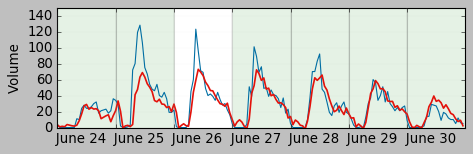

In [34]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

plt.style.use('classic')
fig = plt.figure(figsize=(6, 2))
ax = fig.add_axes([0.12,0.15,0.85,0.75])
plt.plot(small_dense_tensor[16, 12, :], color = "#006ea3",linewidth = 1.0, label = "Actual value")
plt.plot(tensor_hat[16, 12, :], color = "#e3120b", linewidth = 1.5, label = "Predicted value")
ax.set_xlim([0, pred_time_steps])
ax.set_ylim([0, 150])
ax.grid(color = 'gray', linestyle = '-', linewidth = 0.1, alpha = 0.2)
small_sparse_tensor = sparse_tensor[:, :, dense_tensor.shape[2] - pred_time_steps : dense_tensor.shape[2]]
for j in range(7):
    if small_sparse_tensor[16, 12, 24 * j] > 0:
        someX, someY = j * 24, 0
        currentAxis = plt.gca()
        ax.add_patch(patches.Rectangle((someX, someY), 24, 150, alpha = 0.1, facecolor = 'green'))

plt.xticks(np.arange(0, 7 * 24, 24), ["           June 24", "           June 25", 
                                        "           June 26", "           June 27", 
                                       "           June 28", "           June 29", 
                                       "           June 30"])
ax.set_ylabel("Volume")
ax.grid(color = 'gray', linestyle = '-', linewidth = 0.4, alpha = 0.5, axis = 'x')
plt.show()
fig.savefig("images/NYC_time_series_volume_1713.pdf")

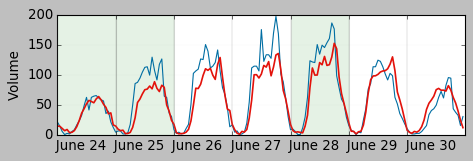

In [35]:
fig = plt.figure(figsize=(6, 2))
ax = fig.add_axes([0.12,0.15,0.85,0.75])
plt.plot(small_dense_tensor[26, 26, :], color = "#006ea3",linewidth = 1.0, label = "Actual value")
plt.plot(tensor_hat[26, 26, :], color = "#e3120b", linewidth = 1.5, label = "Predicted value")
ax.set_xlim([0, pred_time_steps])
ax.set_ylim([0, 200])
ax.grid(color = 'gray', linestyle = '-', linewidth = 0.1, alpha = 0.2)
small_sparse_tensor = sparse_tensor[:, :, dense_tensor.shape[2] - pred_time_steps : dense_tensor.shape[2]]
for j in range(7):
    if small_sparse_tensor[26, 26, 24 * j] > 0:
        someX, someY = j * 24, 0
        currentAxis = plt.gca()
        ax.add_patch(patches.Rectangle((someX, someY), 24, 200, alpha = 0.1, facecolor = 'green'))

plt.xticks(np.arange(0, 7 * 24, 24), ["           June 24", "           June 25", 
                                        "           June 26", "           June 27", 
                                       "           June 28", "           June 29", 
                                       "           June 30"])
ax.set_ylabel("Volume")
ax.grid(color = 'gray', linestyle = '-', linewidth = 0.4, alpha = 0.5, axis = 'x')
plt.show()
fig.savefig("images/NYC_time_series_volume_2727.pdf")

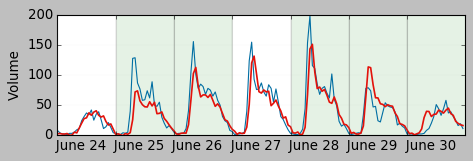

In [36]:
fig = plt.figure(figsize=(6, 2))
ax = fig.add_axes([0.12,0.15,0.85,0.75])
plt.plot(small_dense_tensor[16, 26, :], color = "#006ea3",linewidth = 1.0, label = "Actual value")
plt.plot(tensor_hat[16, 26, :], color = "#e3120b", linewidth = 1.5, label = "Predicted value")
ax.set_xlim([0, pred_time_steps])
ax.set_ylim([0, 200])
ax.grid(color = 'gray', linestyle = '-', linewidth = 0.1, alpha = 0.2)
small_sparse_tensor = sparse_tensor[:, :, dense_tensor.shape[2] - pred_time_steps : dense_tensor.shape[2]]
for j in range(7):
    if small_sparse_tensor[16, 26, 24 * j] > 0:
        someX, someY = j * 24, 0
        currentAxis = plt.gca()
        ax.add_patch(patches.Rectangle((someX, someY), 24, 200, alpha = 0.1, facecolor = 'green'))

plt.xticks(np.arange(0, 7 * 24, 24), ["           June 24", "           June 25", 
                                        "           June 26", "           June 27", 
                                       "           June 28", "           June 29", 
                                       "           June 30"])
ax.set_ylabel("Volume")
ax.grid(color = 'gray', linestyle = '-', linewidth = 0.4, alpha = 0.5, axis = 'x')
plt.show()
fig.savefig("images/NYC_time_series_volume_1727.pdf")